<a href="https://colab.research.google.com/github/ShivamSharma1098/Hospital-Readmissions/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyspark

In [2]:
from pyspark.sql import SparkSession
session= SparkSession.builder.appName("finalProject").getOrCreate()

In [3]:
data=session.read.csv('diabetic_data.csv', header=True, inferSchema=True)

In [4]:
#print("Number of observations:",data.count())

data.describe().show()


+-------+--------------------+--------------------+------+---------------+--------+--------+-----------------+------------------------+-------------------+------------------+----------+-----------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|summary|        encounter_id|         patient_nbr|  race|         gender|     age|  weight|admission_type_id|discharge_disposition_id|admission_source_id|  time_in_hospital|payer_code|medical_specialty|num_lab_procedures|    num_proce

In [5]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


In [6]:
data.show(2)

+------------+-----------+---------+------+-------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|     race|gender|    age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_s

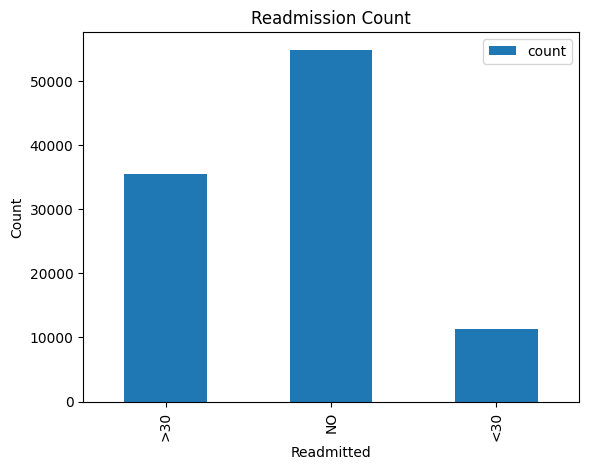

In [7]:
target_count = data.groupBy("readmitted").count()
target_count_pd = target_count.toPandas().set_index("readmitted")
target_count_pd.plot(kind='bar', title='Readmission Count')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.show()


In [8]:
data1= data.toPandas()
train = data1.copy(deep=True)

In [9]:
import pandas as pd

In [10]:
df = []
# Checkthe percentage of the missing values
for col in train.columns:
    if train[col].dtype == object:
        count_missing = train[col][train[col] == '?'].count()
        percent_missing = (count_missing.sum()/train.shape[0]*100).round(2)
#         print(col,count_missing,percent_missing)
        df.append([col,count_missing,percent_missing])
missing_value=pd.DataFrame(df,columns=["col","count_missing","percent_missing"]).sort_values(by="percent_missing",ascending=False)
missing_value

,col,count_missing,percent_missing
3,weight,98569,96.86
5,medical_specialty,49949,49.08
4,payer_code,40256,39.56
0,race,2273,2.23
8,diag_3,1423,1.40
7,diag_2,358,0.35
6,diag_1,21,0.02
29,glyburide-metformin,0,0.00
24,troglitazone,0,0.00
25,tolazamide,0,0.00


In [11]:
columns_to_drop = ['weight', 'medical_specialty', 'payer_code']
train = data.drop(*columns_to_drop)

In [12]:
train.show()

+------------+-----------+---------------+------+--------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|

In [13]:
from pyspark.sql import functions as F

In [14]:
# 1. Dropping rows where 'diag_1', 'diag_2', and 'diag_3' are all '?'
train = train.filter(
    ~(F.col('diag_1') == '?') | ~(F.col('diag_2') == '?') | ~(F.col('diag_3') == '?')
)

# 2. Dropping rows where 'discharge_disposition_id' is 11
train = train.filter(F.col('discharge_disposition_id') != 11)

# For steps 3 and 4, it's useful to first print out the count of missing values for 'gender' and 'race'
# 3. Dropping rows where 'gender' is 'Unknown/Invalid'
# Print the count of 'Unknown/Invalid' gender
gender_invalid_count = train.filter(F.col('gender') == 'Unknown/Invalid').count()
print('gender Unknown/Invalid count:', gender_invalid_count)

train = train.filter(F.col('gender') != 'Unknown/Invalid')

# 4. Dropping rows where 'race' is '?'
# Print the count of '?' race
race_missing_count = train.filter(F.col('race') == '?').count()
print('race "?" count:', race_missing_count)

train = train.filter(F.col('race') != '?')

gender Unknown/Invalid count: 3
race "?" count: 2237


In [15]:
# Drop irrelevant variables and high percent missing variables
train = train.drop("encounter_id", "patient_nbr")

# Drop two attributes 'citoglipton' and 'examide' that have the same value across all rows
train = train.drop("citoglipton", "examide")


In [16]:
# Get the number of rows
num_rows = train.count()

# Get the number of columns
num_columns = len(train.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 97883
Number of columns: 43


In [17]:
from pyspark.sql import functions as F

# Create a new feature 'patient_service'
train = train.withColumn('patient_service', F.col('number_outpatient') + F.col('number_emergency') + F.col('number_inpatient'))

from pyspark.sql.window import Window
from pyspark.sql import functions as F

# 1. Calculate the maximum for normalization
max_outpatient = train.agg(F.max("number_outpatient").alias("max_outpatient")).collect()[0]["max_outpatient"]
max_emergency = train.agg(F.max("number_emergency").alias("max_emergency")).collect()[0]["max_emergency"]
max_inpatient = train.agg(F.max("number_inpatient").alias("max_inpatient")).collect()[0]["max_inpatient"]

# 2. Normalize each variable and create new columns
train = train.withColumn("normalized_outpatient", F.col("number_outpatient") / F.lit(max_outpatient))
train = train.withColumn("normalized_emergency", F.col("number_emergency") / F.lit(max_emergency))
train = train.withColumn("normalized_inpatient", F.col("number_inpatient") / F.lit(max_inpatient))

# Optionally, you can then sum these normalized values to create a combined metric
train = train.withColumn("combined_service_metric",
                         F.col("normalized_outpatient") +
                         F.col("normalized_emergency") +
                         F.col("normalized_inpatient"))



In [18]:
train.show()

+---------------+------+--------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+---------------+---------------------+--------------------+--------------------+-----------------------+
|           race|gender|     age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repag

In [19]:
from pyspark.sql import functions as F
from functools import reduce

# Assuming train is your PySpark DataFrame and keys are defined as before
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide',
        'metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone',
        'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

# Recode the medication use into a binary variable for each medication column
for key in keys:
    col_name = key + 'new'
    train = train.withColumn(col_name, F.when(F.col(key).isin(['No', 'Steady']), 0).otherwise(1))

# Use reduce to sum across the new columns for each row
sum_cols_expr = reduce(lambda a, b: a + b, [F.col(key + 'new') for key in keys])
train = train.withColumn('medicine_change', sum_cols_expr)

# Drop the temporary new columns
train = train.drop(*[key + 'new' for key in keys])


In [20]:
train.show()

+---------------+------+--------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+---------------+---------------------+--------------------+--------------------+-----------------------+---------------+
|           race|gender|     age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult

In [22]:
from pyspark.sql import functions as F

# Count the occurrences of each unique value in the 'medicine_change' column
value_counts = train.groupBy('medicine_change').count().orderBy(F.desc('count'))

# Show the result
value_counts.show()


+---------------+-----+
|medicine_change|count|
+---------------+-----+
|              0|71177|
|              1|25307|
|              2| 1288|
|              3|  106|
|              4|    5|
+---------------+-----+



In [23]:
from pyspark.sql import functions as F

# Assuming 'keys' list is defined as before and 'train' is your DataFrame

# Replace 'No', 'Steady', 'Up', 'Down' with 0 or 1
for key in keys:
    train = train.withColumn(key,
                             F.when(F.col(key) == 'No', 0)
                             .otherwise(1))

# Sum the binary indicators to get the total number of medications used
sum_cols_expr = sum([F.col(key) for key in keys])
train = train.withColumn('num_med', sum_cols_expr)

# Count the occurrences of each unique value in 'num_med'
value_counts_num_med = train.groupBy('num_med').count().orderBy(F.desc('count'))

# Show the result
value_counts_num_med.show()


+-------+-----+
|num_med|count|
+-------+-----+
|      1|45365|
|      0|22454|
|      2|21165|
|      3| 7537|
|      4| 1300|
|      5|   57|
|      6|    5|
+-------+-----+

